## Introduction

Consider the following system:
$$\frac{dx}{dt}=-x-y-x^{2}$$
$$\frac{dy}{dt}=x-y-y^{2}$$

We solve for equilibrium: $(0,0)$ and (numerical approximate) $(0.83928, -1.54368)$. By linearization near the equilibrium and computing the Jacobian matrix, $(0,0)$ is a spiral sink and $(0.83928, -1.54368)$ is a saddle. We are interested to approximate the basin of attraction of $(0,0)$.

In [1]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

spiral_sink = (0, 0)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), spiral_sink) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


In [3]:
def system(t, X):
    x, y = X
    xp = -x-y-x*x
    yp = x-y-y*y
    return xp, yp

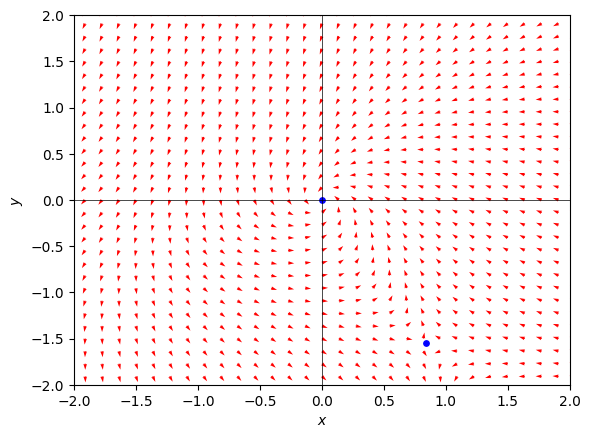

In [4]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.83928], [0, -1.54368], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

## Model training: standard logistic regression

With traditional neural network classfier, we require good initial dataset to achieve good classification result. Suppose the dataset is of poor quality, such as the size is small/all datapoints are concentrated near the attractor, the performance will decay significantly. However, with our approach of data enhancement and adaptive training, we could enhance the dataset based on in-progress training result, reducing dependence on initial dataset. 

In [10]:
# Generate 1000 random points for each dimension
# X = np.random.uniform(-2, 2, 1000)
# Y = np.random.uniform(-2, 2, 1000)

# Create the dataset
# df = pd.DataFrame(columns=['x0', 'y0', 'attracted'])
# for i in tqdm(range(1000)):  # wrap range with tqdm for progress bar
#    x0, y0 = X[i], Y[i]
#    attracted_result = simulation(x0, y0)
#    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
#    df.loc[i] = [x0, y0, attracted_result]


# Save the DataFrame to a CSV file
# df.to_csv('dataset_arbi2d_1000.csv', index=False)

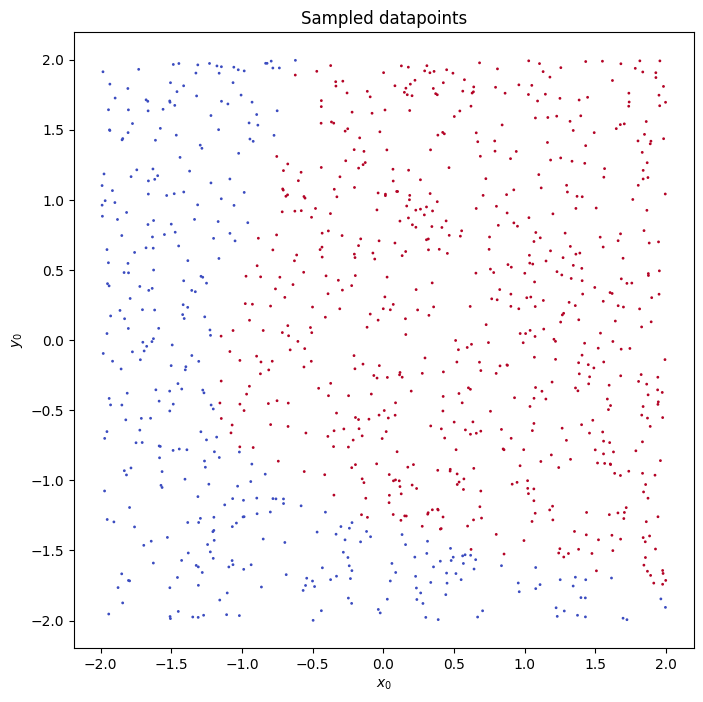

In [5]:
## Plot the sampled datapoints
df = pd.read_csv('dataset_arbi2d_1000.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

In [6]:
class SystemDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y
    
dataset_train = SystemDataset("dataset_arbi2d_1000.csv")


In [7]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    

In [70]:
def train_model_bce(net, dataset_train, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net

def test_model(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    #scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    #plt.colorbar(scatter)

    #plt.show()

    #plt.hist(probability, bins=20)
    #plt.show()
    return accuracy

In [27]:
net_1 = Net()
net_1 = train_model_bce(net_1, dataset_train, 32, 1000, 0.001)

Finished training for epoch 1, loss: 0.643
Finished training for epoch 2, loss: 0.520
Finished training for epoch 3, loss: 0.331
Finished training for epoch 4, loss: 0.200
Finished training for epoch 5, loss: 0.128
Finished training for epoch 6, loss: 0.090
Finished training for epoch 7, loss: 0.074
Finished training for epoch 8, loss: 0.064
Finished training for epoch 9, loss: 0.053
Finished training for epoch 10, loss: 0.049
Finished training for epoch 11, loss: 0.043
Finished training for epoch 12, loss: 0.039
Finished training for epoch 13, loss: 0.037
Finished training for epoch 14, loss: 0.033
Finished training for epoch 15, loss: 0.039
Finished training for epoch 16, loss: 0.033
Finished training for epoch 17, loss: 0.030
Finished training for epoch 18, loss: 0.029
Finished training for epoch 19, loss: 0.029
Finished training for epoch 20, loss: 0.026
Finished training for epoch 21, loss: 0.025
Finished training for epoch 22, loss: 0.023
Finished training for epoch 23, loss: 0.0

In [32]:
dataset_uniform_test = SystemDataset("dataset_arbi2d.csv")

In [33]:
test_model(net_1, dataset_uniform_test)

Accuracy: 0.9953500032424927


tensor(0.9954)

In [34]:
## We test the model by near-boundary points generated previously via bisection routine.
dataset_near_test = SystemDataset("dataset_arbi2d_near.csv")

In [35]:
test_model(net_1, dataset_near_test)

Accuracy: 0.5551000237464905


tensor(0.5551)

When the training set is small, we could see that the classifier does not give good performance if tested by points that are close to the boundary.

## Model training: data enhancement with near-boundaty points

In [ ]:
df_data = dataset_train.data

df_data_1 = df_data[df_data['attracted'] == 1].sample(40)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(40)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_arbi2d_enhanced_1600.csv', index=False)

Processing df_1: 100%|██████████| 40/40 [06:40<00:00, 10.02s/it]


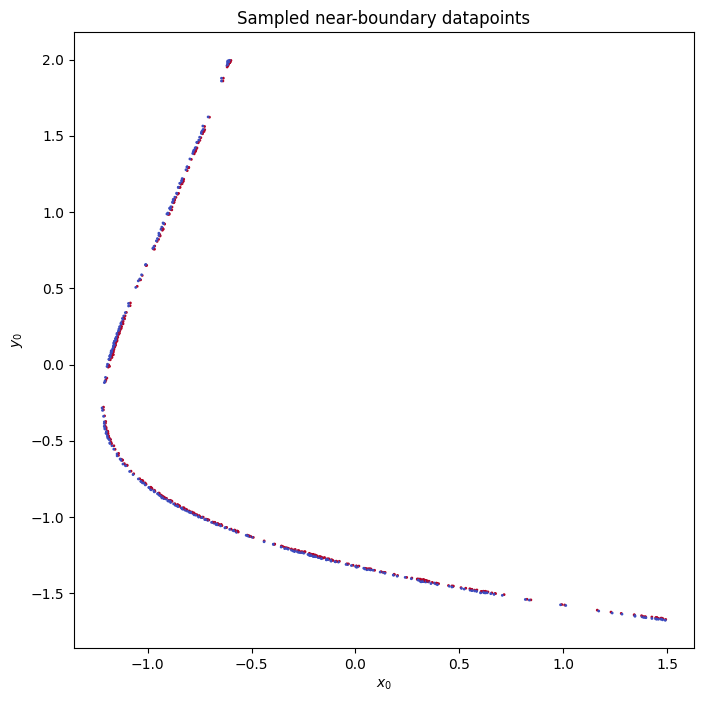

In [59]:
## Verify the generated near-boundary points
df_near = pd.read_csv('dataset_arbi2d_enhanced_400.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df_near['x0'], df_near['y0'], c=df_near['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled near-boundary datapoints')
plt.show()

In [60]:
## Train the model again with enhanced dataset
dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_400.csv")
dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])

In [61]:
net_2 = Net()
net_2 = train_model_bce(net_2, dataset_merged_train, 32, 1000, 0.001)

Finished training for epoch 1, loss: 0.655
Finished training for epoch 2, loss: 0.547
Finished training for epoch 3, loss: 0.480
Finished training for epoch 4, loss: 0.433
Finished training for epoch 5, loss: 0.401
Finished training for epoch 6, loss: 0.383
Finished training for epoch 7, loss: 0.371
Finished training for epoch 8, loss: 0.371
Finished training for epoch 9, loss: 0.354
Finished training for epoch 10, loss: 0.353
Finished training for epoch 11, loss: 0.353
Finished training for epoch 12, loss: 0.367
Finished training for epoch 13, loss: 0.344
Finished training for epoch 14, loss: 0.342
Finished training for epoch 15, loss: 0.340
Finished training for epoch 16, loss: 0.339
Finished training for epoch 17, loss: 0.345
Finished training for epoch 18, loss: 0.343
Finished training for epoch 19, loss: 0.337
Finished training for epoch 20, loss: 0.345
Finished training for epoch 21, loss: 0.337
Finished training for epoch 22, loss: 0.334
Finished training for epoch 23, loss: 0.3

In [62]:
test_model(net_2, dataset_uniform_test)

Accuracy: 0.9990299940109253


tensor(0.9990)

In [63]:
test_model(net_2, dataset_near_test)

Accuracy: 0.8331500291824341


tensor(0.8332)

We could see that with enhanced training set, we still retain good accuracy on universally-drawn test data, but achived improved accuracy on near-boundary test data as well.

## CustomLoss

We impose normality condition on near-boundary training points.

In [64]:
class SystemDatasetModified(Dataset):
    def __init__(self, csv_file, indicator):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.apply(pd.to_numeric, errors='coerce', axis=1)
        self.data['indicator'] = indicator

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values.astype('float32')).float()
        y = torch.tensor(self.data.iloc[idx, 2], dtype=torch.float32)
        indicator = torch.tensor(self.data.iloc[idx, 3], dtype=torch.float32)
        return x, y, indicator

    def append_data(self, new_data):
        # Identify columns that are either completely empty or contain all NA values
        cols_to_exclude = new_data.columns[new_data.isna().all()]

        # Exclude these columns from new_data
        new_data_filtered = new_data.drop(columns=cols_to_exclude)

        # Concatenate dataframes, now excluding the empty or all-NA columns
        self.data = pd.concat([self.data, new_data_filtered], ignore_index=True)
    
dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_400.csv", 1)
dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])


    

In [95]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude

    def forward(self, predictions, labels, inputs, b, indicators):
        predictions_flat = predictions.view(-1)
        labels_flat = labels.float().view(-1)
        
        l = nn.BCELoss()(predictions_flat, labels_flat)

        for i, indicator in enumerate(indicators):
            if indicator == 1:
                grad_input = inputs[i].unsqueeze(0).clone().detach().requires_grad_(True)
                grad_prediction = predictions_flat[i].unsqueeze(0)  
                grads = torch.autograd.grad(grad_prediction.sum(), grad_input, create_graph=True, allow_unused=True)[0]
                
                if grads is not None:
                    norm_grads = grads / grads.norm(dim=1, keepdim=True)
                    norm_b = b[i].unsqueeze(0) / b[i].norm(dim=0, keepdim=True)
                    inner_product = (norm_grads * norm_b).sum(dim=1)**2
                    l += self.magnitude * inner_product.sum()
        
        return l

def train_model_custom(net, dataset_train, batchsize, epochs, lr, magnitude):
    criterion = CustomLoss(magnitude)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels, indicators in dataloader_train: 
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, system(0, features.T), indicators)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        
        print(f'Finished training for epoch {epoch + 1}, loss: {running_loss / mini_batch_count:.3f}')
    
    return net

def test_model_modified(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels, _ in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    #fig = plt.figure()
    #ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    #scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    #plt.colorbar(scatter)

    #plt.show()

    #plt.hist(probability, bins=20)
    #plt.show()
    return accuracy

In [96]:
net_3 = Net()
net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 1000, 0.001, 8579.598230609947)

Finished training for epoch 1, loss: 0.648
Finished training for epoch 2, loss: 0.518
Finished training for epoch 3, loss: 0.456
Finished training for epoch 4, loss: 0.406
Finished training for epoch 5, loss: 0.388
Finished training for epoch 6, loss: 0.370
Finished training for epoch 7, loss: 0.362
Finished training for epoch 8, loss: 0.359
Finished training for epoch 9, loss: 0.353
Finished training for epoch 10, loss: 0.346
Finished training for epoch 11, loss: 0.349
Finished training for epoch 12, loss: 0.340
Finished training for epoch 13, loss: 0.341
Finished training for epoch 14, loss: 0.336
Finished training for epoch 15, loss: 0.331
Finished training for epoch 16, loss: 0.333
Finished training for epoch 17, loss: 0.330
Finished training for epoch 18, loss: 0.332
Finished training for epoch 19, loss: 0.336
Finished training for epoch 20, loss: 0.331
Finished training for epoch 21, loss: 0.328
Finished training for epoch 22, loss: 0.328
Finished training for epoch 23, loss: 0.3

In [97]:
dataset_uniform_test_modified = SystemDatasetModified("dataset_arbi2d.csv", 0)
dataset_near_test_modified = SystemDatasetModified("dataset_arbi2d_near.csv", 1)

In [98]:
test_model_modified(net_3, dataset_uniform_test_modified)

Accuracy: 0.9985899925231934


tensor(0.9986)

In [99]:
test_model_modified(net_3, dataset_near_test_modified)

Accuracy: 0.7253999710083008


tensor(0.7254)

In [ ]:
accuracy_uniform_1 = 0
accuracy_near_1 = 0
accuracy_uniform_2 = 0
accuracy_near_2 = 0
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(10):
    print(f'Iteration {i + 1}')
    
    net_1 = Net()
    dataset_train_1 = SystemDataset("dataset_arbi2d_1000.csv")
    net_1 = train_model_bce(net_1, dataset_train_1, 32, 100, 0.001)

    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_1600.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 100, 0.001)

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_1600.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 100, 0.001, 8442.813220061595)

    accuracy_uniform_1 += test_model(net_1, dataset_uniform_test)
    accuracy_near_1 += test_model(net_1, dataset_near_test)
    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)
    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 1: {accuracy_uniform_1 / 10}')
print(f'Average accuracy for near test set with model 1: {accuracy_near_1 / 10}')
print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 10}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 10}')
print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 10}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 10}')

Iteration 1
Accuracy: 0.995710015296936
Accuracy: 0.5703499913215637
Accuracy: 0.9985899925231934
Accuracy: 0.7597500085830688
Accuracy: 0.998769998550415
Accuracy: 0.7280499935150146
Iteration 2
Accuracy: 0.9957000017166138
Accuracy: 0.6208000183105469
Accuracy: 0.9971100091934204
Accuracy: 0.6136000156402588
Accuracy: 0.9978399872779846
Accuracy: 0.6050500273704529
Iteration 3
Accuracy: 0.9942399859428406
Accuracy: 0.5706999897956848
Accuracy: 0.9975000023841858
Accuracy: 0.5347999930381775
Accuracy: 0.9986500144004822
Accuracy: 0.6388499736785889
Iteration 4
Accuracy: 0.9933500289916992
Accuracy: 0.6016499996185303
Accuracy: 0.998199999332428
Accuracy: 0.5878999829292297
Accuracy: 0.9988099932670593
Accuracy: 0.7616999745368958
Iteration 5
Accuracy: 0.9924600124359131
Accuracy: 0.5188500285148621
Accuracy: 0.9973400235176086
Accuracy: 0.612500011920929
Accuracy: 0.9980400204658508
Accuracy: 0.696150004863739
Iteration 6
Accuracy: 0.992169976234436
Accuracy: 0.5425999760627747
Accura

In [73]:

accuracy_uniform_2 = 0
accuracy_near_2 = 0


for i in range(50):
    print(f'Iteration {i + 1}')
    
    net_2 = Net()
    dataset_uniform_train = SystemDataset("dataset_arbi2d_1000.csv")
    dataset_near_train = SystemDataset("dataset_arbi2d_enhanced_400.csv")
    dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
    net_2 = train_model_bce(net_2, dataset_merged_train, 32, 1000, 0.001)

    accuracy_uniform_2 += test_model(net_2, dataset_uniform_test)
    accuracy_near_2 += test_model(net_2, dataset_near_test)

print(f'Average accuracy for uniform test set with model 2: {accuracy_uniform_2 / 50}')
print(f'Average accuracy for near test set with model 2: {accuracy_near_2 / 50}')

Iteration 1
Accuracy: 0.9987999796867371
Accuracy: 0.7473999857902527
Iteration 2
Accuracy: 0.9986000061035156
Accuracy: 0.7853000164031982
Iteration 3
Accuracy: 0.9987599849700928
Accuracy: 0.7303500175476074
Iteration 4
Accuracy: 0.9982900023460388
Accuracy: 0.7143999934196472
Iteration 5
Accuracy: 0.9993299841880798
Accuracy: 0.8738499879837036
Iteration 6
Accuracy: 0.9987000226974487
Accuracy: 0.7813500165939331
Iteration 7
Accuracy: 0.9993900060653687
Accuracy: 0.8648499846458435
Iteration 8
Accuracy: 0.999239981174469
Accuracy: 0.845300018787384
Iteration 9
Accuracy: 0.9991000294685364
Accuracy: 0.8141999840736389
Iteration 10
Accuracy: 0.9985499978065491
Accuracy: 0.6807000041007996
Iteration 11
Accuracy: 0.9992600083351135
Accuracy: 0.8646500110626221
Iteration 12
Accuracy: 0.9990900158882141
Accuracy: 0.7172999978065491
Iteration 13
Accuracy: 0.9988800287246704
Accuracy: 0.8895999789237976
Iteration 14
Accuracy: 0.9994099736213684
Accuracy: 0.8838499784469604
Iteration 15
Accu

In [81]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the objective function for Bayesian Optimization
def objective_function(magnitude):
    accuracy_near_3 = 0
    
    for i in range(50):
        net_3 = Net()
        dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
        dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_400.csv", 1)
        dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
        net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 1000, 0.001, magnitude)
        
        accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified).item()
    
    # Calculate average accuracy
    average_accuracy_near_3 = accuracy_near_3 / 3
    
    # Return negative accuracy because gp_minimize seeks to minimize the function
    return -average_accuracy_near_3

# Define the range for 'magnitude'
space = [Real(1, 10000, name='magnitude')]

# Use named args for convenience
@use_named_args(space)
def objective(**params):
    # Pass the entire params dictionary to the objective_function
    return objective_function(**params)

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=20, n_jobs=-1, random_state=0, verbose=True)

# Output the best result
print(f"Best magnitude: {result.x[0]}")
print(f"Best average accuracy: {-result.fun}")
best_magnitude = result.x[0]

Iteration No: 1 started. Evaluating function at random point.
Accuracy: 0.8434500098228455
Accuracy: 0.8025000095367432
Accuracy: 0.6996999979019165
Accuracy: 0.8514000177383423
Accuracy: 0.8884999752044678
Accuracy: 0.9013000130653381
Accuracy: 0.736549973487854
Accuracy: 0.725350022315979
Accuracy: 0.8250499963760376
Accuracy: 0.8926500082015991
Accuracy: 0.8576499819755554
Accuracy: 0.8655499815940857
Accuracy: 0.8514500260353088
Accuracy: 0.7992500066757202
Accuracy: 0.8424999713897705
Accuracy: 0.8537999987602234
Accuracy: 0.7361000180244446
Accuracy: 0.7174999713897705
Accuracy: 0.7762500047683716
Accuracy: 0.8208500146865845
Accuracy: 0.862500011920929
Accuracy: 0.8146499991416931
Accuracy: 0.8536499738693237
Accuracy: 0.7886499762535095
Accuracy: 0.797249972820282
Accuracy: 0.7387999892234802
Accuracy: 0.7070500254631042
Accuracy: 0.8984000086784363
Accuracy: 0.7512999773025513
Accuracy: 0.8277999758720398
Accuracy: 0.8080000281333923
Accuracy: 0.7767500281333923
Accuracy: 0.83

In [82]:
accuracy_uniform_3 = 0
accuracy_near_3 = 0

for i in range(50):
    print(f'Iteration {i + 1}')

    net_3 = Net()
    dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
    dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_400.csv", 1)
    dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])
    net_3 = train_model_custom(net_3, dataset_merged_train_modified, 32, 1000, 0.001, best_magnitude)

    accuracy_uniform_3 += test_model_modified(net_3, dataset_uniform_test_modified)
    accuracy_near_3 += test_model_modified(net_3, dataset_near_test_modified)

print(f'Average accuracy for uniform test set with model 3: {accuracy_uniform_3 / 50}')
print(f'Average accuracy for near test set with model 3: {accuracy_near_3 / 50}')

Iteration 1


KeyboardInterrupt: 

## Adaptive training

In [107]:
def generate_close_points(instance, indicators, n=1, distance=0.0005):
    close_points = []
    for point, indicator in zip(instance, indicators):
        for _ in range(n):
            new_point = (point[0]+np.random.uniform(-distance, distance), point[1]+np.random.uniform(-distance, distance))
            attracted = simulation(new_point[0], new_point[1])
            close_points.append((new_point[0], new_point[1], attracted, indicator))
    df = pd.DataFrame(close_points, columns=['x0', 'y0', 'attracted', 'indicator'])
    return df
    

In [108]:
dataset_uniform_train_modified = SystemDatasetModified("dataset_arbi2d_1000.csv", 0)
dataset_near_train_modified = SystemDatasetModified("dataset_arbi2d_enhanced_400.csv", 1)
dataset_merged_train_modified = torch.utils.data.ConcatDataset([dataset_uniform_train_modified, dataset_near_train_modified])

def train_model_custom_augmented(net, dataset_uniform_train, dataset_near_train, batchsize, epochs, lr, magnitude, generate_close_points):
    criterion = CustomLoss(magnitude)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(epochs):
        dataset_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
        dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
        running_loss = 0.0
        mini_batch_count = 0
        correct_predictions = 0
        total_predictions = 0
        misclassified_features_lst = []
        misclassified_indicators_lst = []
        
        for features, labels, indicators in dataloader_train: 
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, system(0, features.T), indicators)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
            
            # Identify misclassified instances
            with torch.no_grad():
                predicted_labels = (outputs > 0.5).float()
                misclassified_mask = predicted_labels != labels
                misclassified_features = features[misclassified_mask]
                misclassified_indicators = indicators[misclassified_mask]
                misclassified_features_lst.extend(misclassified_features.numpy())
                misclassified_indicators_lst.extend(misclassified_indicators.numpy())
                correct_predictions += (predicted_labels == labels).sum().item()
                total_predictions += labels.size(0)

        
        # Generate and add new data points for misclassified instances
        if (epoch + 1) % 1000 == 0:
            new_data_points = generate_close_points(misclassified_features_lst, misclassified_indicators_lst)
            dataset_near_train.append_data(new_data_points)
        training_accuracy = correct_predictions / total_predictions
        
        print(f'Finished training for epoch {epoch + 1}, loss: {running_loss / mini_batch_count:.3f}, accuracy: {training_accuracy:.3f}, training set size: {len(dataset_train)}')
    
    return net

In [109]:
net_adaptive = Net()
ner_adaptive = train_model_custom_augmented(net_adaptive, dataset_uniform_train_modified, dataset_near_train_modified, 32, 5000, 0.001, best_magnitude, generate_close_points)

Finished training for epoch 1, loss: 0.657, accuracy: 0.640, training set size: 1800
Finished training for epoch 2, loss: 0.533, accuracy: 0.722, training set size: 1800
Finished training for epoch 3, loss: 0.448, accuracy: 0.756, training set size: 1800
Finished training for epoch 4, loss: 0.402, accuracy: 0.761, training set size: 1800
Finished training for epoch 5, loss: 0.385, accuracy: 0.765, training set size: 1800
Finished training for epoch 6, loss: 0.371, accuracy: 0.773, training set size: 1800
Finished training for epoch 7, loss: 0.372, accuracy: 0.763, training set size: 1800
Finished training for epoch 8, loss: 0.359, accuracy: 0.774, training set size: 1800
Finished training for epoch 9, loss: 0.353, accuracy: 0.774, training set size: 1800
Finished training for epoch 10, loss: 0.351, accuracy: 0.779, training set size: 1800
Finished training for epoch 11, loss: 0.345, accuracy: 0.783, training set size: 1800
Finished training for epoch 12, loss: 0.346, accuracy: 0.777, t

In [110]:
test_model_modified(net_adaptive, dataset_uniform_test_modified)
test_model_modified(net_adaptive, dataset_near_test_modified)

Accuracy: 0.9988499879837036
Accuracy: 0.7835000157356262


tensor(0.7835)